In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
from sklearn.metrics import mean_squared_error as mse_func
from scipy.stats import pearsonr

adata = sc.read_h5ad('../../data/Data_GEARS/adamson/perturb_processed.h5ad')
ctrl = adata[adata.obs['condition']=='ctrl'].X.toarray().mean(axis=0)

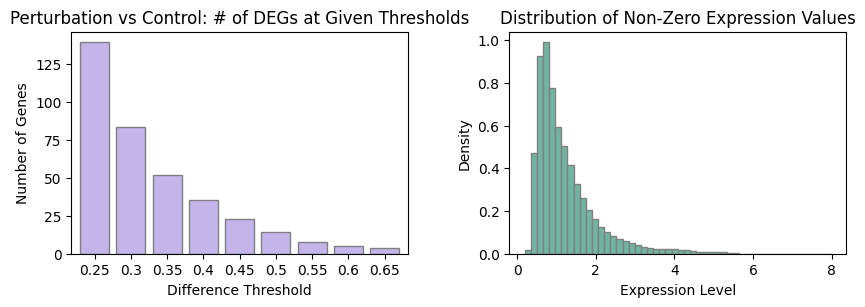

In [2]:
########################## EDA ##########################
unq_perts = set(adata.obs['condition']).difference({'ctrl'})
large_diffs = {}
for pert in unq_perts:
    treatment = adata[adata.obs['condition']==pert].X.toarray().mean(axis=0)
    control = adata[adata.obs['condition']=='ctrl'].X.toarray().mean(axis=0)
    pert_dict = {}
    for threshold in np.arange(0.25, 0.7, 0.05):
        diff_counts = sum(abs(treatment-control) > round(threshold, 2))
        pert_dict[round(threshold, 2)] = diff_counts
    large_diffs[pert] = pert_dict
median_counts = pd.DataFrame(large_diffs).T.median()

# Histogram of non-zero expression values
expr_matrix = adata.X.toarray()
nonzero_expr = expr_matrix[expr_matrix > 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
median_counts.plot(kind='bar',
                   ax=axes[0],
                   edgecolor='gray',
                   width=0.8,
                   color='#c3b5ea',
                   legend=False)
axes[0].set_xlabel("Difference Threshold")
axes[0].set_ylabel('Number of Genes')
axes[0].set_title('Perturbation vs Control: # of DEGs at Given Thresholds')
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='y')

axes[1].hist(nonzero_expr, bins=50, color='#70b5a1', edgecolor='gray', density=True)
axes[1].set_xlabel('Expression Level')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of Non-Zero Expression Values')
axes[1].tick_params(axis='both')

plt.subplots_adjust(wspace=0.3, top=0.85)
plt.show()

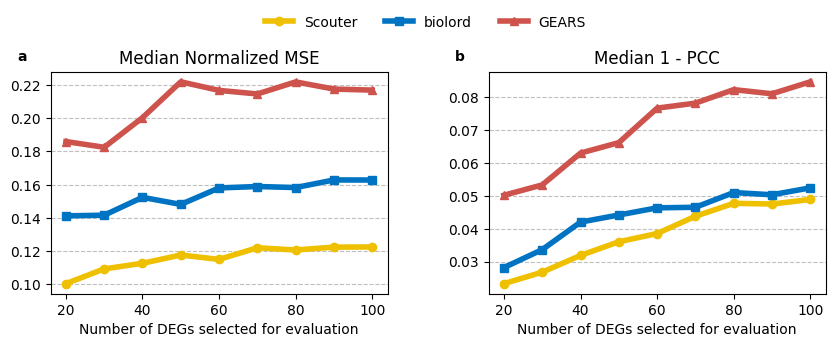

In [3]:
########################## Read DEGs ##########################
with open('../extra//more_degs/adamson_degs.pkl', 'rb') as f:
    degs_ls = pickle.load(f)
    # del degs_ls[20]
    # remove the pert itself from the degs because it is a misleading DEG
    for top_n, degs in degs_ls.items():
        for pert, degs in degs.items():
            pert_name = pert.split("+")[0]
            pert_idx = pd.Index(adata.var.gene_name).get_loc(pert_name)
            new_degs = sorted(set(degs).difference({pert_idx}))
            degs_ls[top_n][pert] = new_degs

########################## Scouter ##########################
mse_scouter = []; minus_pcc_scouter = []; perts = []
for split in range(1,6):
    with open(f'../extra//more_degs/Scouter_adamson_{split}.pkl', 'rb') as f:
        scouter_result = pickle.load(f)
    scouter_result = {k:v.mean(axis=0) for k, v in scouter_result.items()}
    for pert, pred in scouter_result.items():
        mse_pert = {}
        minus_pcc_pert = {}
        true = adata[adata.obs['condition']==pert].X.toarray().mean(axis=0)
        for top_n, degs in degs_ls.items():
            degs_idx = degs[pert]
            true_degs = true[degs_idx]
            pred_degs = pred[degs_idx]
            ctrl_degs = ctrl[degs_idx]
            mse_pert[top_n] = mse_func(true_degs, pred_degs)/mse_func(true_degs, ctrl_degs)
            minus_pcc_pert[top_n] = 1 - pearsonr(true_degs-ctrl_degs, pred_degs-ctrl_degs)[0]
        mse_scouter.append(mse_pert)
        minus_pcc_scouter.append(minus_pcc_pert)
        perts.append(pert)

mse_scouter = pd.DataFrame(mse_scouter, index=perts)
minus_pcc_scouter = pd.DataFrame(minus_pcc_scouter, index=perts)

########################## GEARS ##########################
mse_gears = []; minus_pcc_gears = []; perts = []
for split in range(1,6):
    with open(f'../../results/GEARS/GEARS_adamson_{split}.pkl', 'rb') as f:
        gears_result = pickle.load(f)
    for pert, values in gears_result.items():
        true, pred, ctrl = values['Truth'], values['Pred'], values['Ctrl']
        mse_pert = {}
        minus_pcc_pert = {}
        for top_n, degs in degs_ls.items():
            degs_idx = degs[f'{pert}+ctrl']
            true_degs = true[degs_idx]
            pred_degs = pred[degs_idx]
            ctrl_degs = ctrl[degs_idx]
            mse_pert[top_n] = mse_func(true_degs, pred_degs)/mse_func(true_degs, ctrl_degs)
            minus_pcc_pert[top_n] = 1 - pearsonr(true_degs-ctrl_degs, pred_degs-ctrl_degs)[0]
        mse_gears.append(mse_pert)
        minus_pcc_gears.append(minus_pcc_pert)
        perts.append(pert)

mse_gears = pd.DataFrame(mse_gears, index=perts)
minus_pcc_gears = pd.DataFrame(minus_pcc_gears, index=perts)
mse_gears.median()
minus_pcc_gears.median()

########################## biolord ##########################
mse_biolord = []; minus_pcc_biolord = []; perts = []
for split in range(1, 6):
    with open(f'../../results/Biolord/Biolord_adamson_{split}.pkl', 'rb') as f:
        biolord_result = pickle.load(f)
    biolord_result = {k.split("_")[1]:v for k, v in biolord_result.items()}
    for pert, values in biolord_result.items():
        true, pred, ctrl = values['Truth'], values['Pred'], values['Ctrl']
        mse_pert = {}
        minus_pcc_pert = {}
        for top_n, degs in degs_ls.items():
            degs_idx = degs[pert]
            true_degs = true[degs_idx]
            pred_degs = pred[degs_idx]
            ctrl_degs = ctrl[degs_idx]
            mse_pert[top_n] = mse_func(true_degs, pred_degs)/mse_func(true_degs, ctrl_degs)
            minus_pcc_pert[top_n] = 1 - pearsonr(true_degs-ctrl_degs, pred_degs-ctrl_degs)[0]
        mse_biolord.append(mse_pert)
        minus_pcc_biolord.append(minus_pcc_pert)
        perts.append(pert)

mse_biolord = pd.DataFrame(mse_biolord, index=perts)
minus_pcc_biolord = pd.DataFrame(minus_pcc_biolord, index=perts)
mse_biolord.median()
minus_pcc_biolord.median()


########################## Plot ##########################
mse_combined = pd.DataFrame({
    'Scouter': mse_scouter.median(),
    'biolord': mse_biolord.median(), 
    'GEARS': mse_gears.median()
})

minus_pcc_combined = pd.DataFrame({
    'Scouter': minus_pcc_scouter.median(),
    'biolord': minus_pcc_biolord.median(), 
    'GEARS': minus_pcc_gears.median()
})


fig, axes = plt.subplots(1, 2, figsize=(10, 3))
colors = ["#efc000", "#0073c2", "#cd534c"]
methods = ['Scouter', 'biolord', 'GEARS']
markers = ['o', 's', '^']  # circle, square, triangle

# Left plot: Median Normalized MSE
for method, color, marker in zip(methods, colors, markers):
    axes[0].plot(mse_combined.index, mse_combined[method],
                 label=method, color=color, marker=marker, linewidth=4)

axes[0].set_xlabel("Number of DEGs selected for evaluation")
# axes[0].set_ylabel("Median Normalized MSE")
axes[0].set_title("Median Normalized MSE")
axes[0].tick_params(axis='both')

# Right plot: Median 1 - PCC
for method, color, marker in zip(methods, colors, markers):
    axes[1].plot(minus_pcc_combined.index, minus_pcc_combined[method],
                 label=method, color=color, marker=marker, linewidth=4)

axes[1].set_xlabel("Number of DEGs selected for evaluation")
# axes[1].set_ylabel("Median 1 - PCC")
axes[1].set_title("Median 1 - PCC")
axes[1].tick_params(axis='both')

# Subfigure labels
axes[0].text(-0.1, 1.1, "a", transform=axes[0].transAxes,
             fontweight="bold", va="top")
axes[1].text(-0.1, 1.1, "b", transform=axes[1].transAxes,
             fontweight="bold", va="top")

# Legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
           bbox_to_anchor=(0.5, 1.08),
           ncol=3, frameon=False)
# Add horizontal grid lines
axes[0].grid(axis='y', linestyle='--', alpha=0.5, color='gray')
axes[1].grid(axis='y', linestyle='--', alpha=0.5, color='gray')

plt.subplots_adjust(wspace=0.3, top=0.85)
plt.show()